In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from time import time
from tensorflow.keras.callbacks import TensorBoard
from Constants import *

In [2]:
data.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
data.shape

(1600000, 6)

In [4]:
data = data.sample(frac = 1)
data = data[:100000]

In [5]:
data.rename(columns = {
                    "polarity" : "Polarity",
                    "text" : "Text"
                    }, inplace = True)

In [6]:
data["Polarity"] = data["Polarity"].replace(4, 1)

In [7]:
num_classes = len(data["Polarity"].unique())
print(data["Polarity"].unique())
print(num_classes)

[1 0]
2


- Polarity Sentiment labels;
- 0 : Negative
- 1 : Positive

In [8]:
Positive_tweets = data["Polarity"][data.Polarity == 1]
Negative_tweets = data["Polarity"][data.Polarity == 0]

print("Number of Positive tweets: {}".format(len(Positive_tweets)))
print("Number of Negative tweets: {}".format(len(Negative_tweets)))

Number of Positive tweets: 50109
Number of Negative tweets: 49891


In [9]:
data.drop(["date", "id", "query", "user"], axis = 1, inplace = True)

In [10]:
data.isnull().sum()

Polarity    0
Text        0
dtype: int64

In [11]:
data.iloc[1]

Polarity                                                    0
Text        @veronicasmusic I wish I could be at the dalla...
Name: 583234, dtype: object

In [12]:
data[data.columns[:1]]

,Polarity
967711,1
583234,0
949351,1
1578439,1
1512115,1
...,...
778992,0
837883,1
316491,0
1080624,1


In [13]:
X = data['Text']
y = data[data.columns[:1]].values

In [14]:
def custom_standardisation(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_punct = tf.strings.regex_replace(lowercase, 
                                              "{~`!@$%^&*()_+"";.. 1 2 3 4 5 6 7 8 9 0 1234567890 -=[;:/#.,\\t\n|?><']} http:// .com www. twitter. https:// ",
                                         ' ')
    
    return tf.strings.regex_replace(stripped_punct,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

In [15]:
vectoriser = TextVectorization(
    standardize = custom_standardisation,
    max_tokens = MAX_FEATURES,
    output_sequence_length = SEQUENCE_LENGTH,
    output_mode = 'int'
)

In [16]:
vectoriser.adapt(X.values)

In [17]:
print(vectoriser.get_vocabulary()[2])
print(vectoriser.get_vocabulary()[200])
print(vectoriser.get_vocabulary()[1500])

i
cool
delicious


In [18]:
vectorised_text = vectoriser(X.values)
vectorised_text

<tf.Tensor: shape=(100000, 1000), dtype=int64, numpy=
array([[  1,  26,  51, ...,   0,   0,   0],
       [  1,   2, 111, ...,   0,   0,   0],
       [  1, 156,   8, ...,   0,   0,   0],
       ...,
       [  1,  28,  32, ...,   0,   0,   0],
       [599, 240,  47, ...,   0,   0,   0],
       [456,   1,  10, ...,   0,   0,   0]], dtype=int64)>

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vectorised_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8)

In [20]:
train_set = dataset.take(int(len(dataset) * 0.7))
val_set = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_set = dataset.skip(int(len(dataset) * 0.9)).take(int(len(dataset) * 0.1))

In [21]:
model = keras.Sequential([
    layers.Embedding(MAX_FEATURES + 1, 32),
    layers.Bidirectional(layers.LSTM(32, activation = 'tanh')),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [22]:
model.compile(
    optimizer = 'adam',
    loss = 'BinaryCrossentropy',
    metrics = ['accuracy']
)

In [23]:
tensorboard = TensorBoard(log_dir = "logs/{}".format(time()))

In [24]:
history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    callbacks = [tensorboard],
                    epochs = 10
                    )

Epoch 1/10

4375/4375 [==============================] - 2111s 480ms/step - loss: 0.5040 - accuracy: 0.7518 - val_loss: 0.4303 - val_accuracy: 0.8069
Epoch 2/10
4375/4375 [==============================] - 2065s 472ms/step - loss: 0.4403 - accuracy: 0.7960 - val_loss: 0.3926 - val_accuracy: 0.8217
Epoch 3/10
4375/4375 [==============================] - 2057s 470ms/step - loss: 0.4131 - accuracy: 0.8125 - val_loss: 0.3671 - val_accuracy: 0.8346
Epoch 4/10
4375/4375 [==============================] - 2039s 466ms/step - loss: 0.3936 - accuracy: 0.8215 - val_loss: 0.3615 - val_accuracy: 0.8364
Epoch 5/10
4375/4375 [==============================] - 1897s 433ms/step - loss: 0.3776 - accuracy: 0.8301 - val_loss: 0.3503 - val_accuracy: 0.8426
Epoch 6/10
4375/4375 [==============================] - 1887s 431ms/step - loss: 0.3565 - accuracy: 0.8411 - val_loss: 0.3240 - val_accuracy: 0.8566
Epoch 7/10
4375/4375 [==============================] - 1874s 428ms/step - loss: 0.3417 - accuracy: 0.848

In [25]:
model.evaluate(test_set)

625/625 [==============================] - 59s 93ms/step - loss: 0.2680 - accuracy: 0.8841


[0.2680085301399231, 0.8841000199317932]

In [26]:
history = history.history

In [29]:
val_loss = history['val_loss']
loss = history['loss']

val_accuracy = history["val_accuracy"]
accuracy = history["accuracy"]

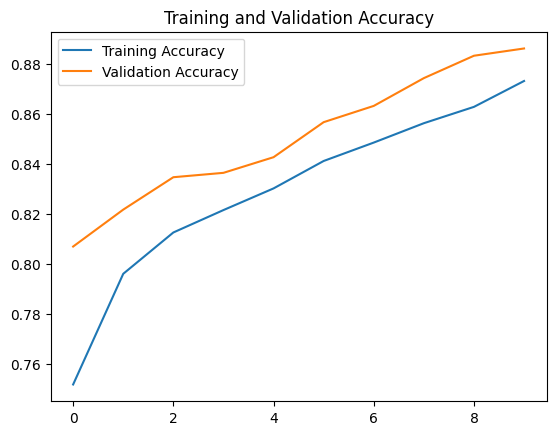

In [30]:
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'upper left')
plt.title("Training and Validation Accuracy")
plt.show()

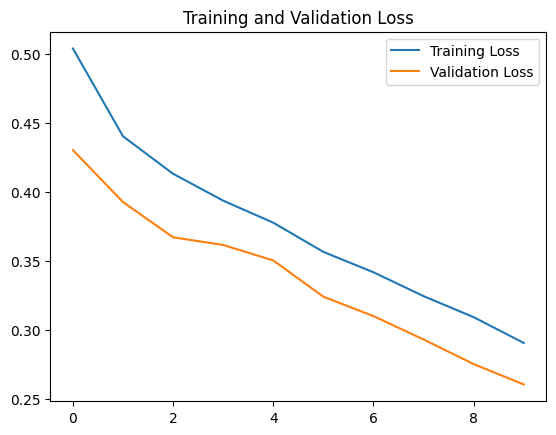

In [31]:
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [32]:
model.save("tweets_1.h5")

In [33]:
model = tf.keras.models.load_model("tweets_1.h5")

In [37]:
sample_text = vectoriser("this data science article is subpar")
prediction = model.predict(np.expand_dims(sample_text, 0))
if prediction > 0.5:
    print('Positive tweet')
else:
    print('Negative tweet')

1/1 [==============================] - 0s 115ms/step
Negative tweet


In [38]:
data.columns[:1]

Index(['Polarity'], dtype='object')

In [ ]:
#create new dataframe for just the two target options

In [118]:
def expand_sentiments(data):
    expanded_data = pd.DataFrame()

    for sentiment_value in range(2):
        sentiment_label = "Negative" if sentiment_value == 0 else "Positive"
        sentiment_column_name = f"{sentiment_label}"
        expanded_data[sentiment_column_name] = (data['Polarity'] == sentiment_value).astype(int)

    return expanded_data

# Expand the encoded values
expanded_data = expand_sentiments(data)

In [131]:
#Sentiment_df = data.copy()
#Sentiment_df = Sentiment_df.join(expanded_data)
Sentiment_df = expanded_data
Sentiment_df.head()

,Negative,Positive
967711,0,1
583234,1,0
949351,0,1
1578439,0,1
1512115,0,1


In [134]:
Sentiment_df.columns[:2]

Index(['Negative', 'Positive'], dtype='object')

In [135]:
def score_comment(comment):
    vectorised_comment = vectoriser([comment])
    result = model.predict(vectorised_comment)
    
    text = ''
    for idx, col in enumerate(Sentiment_df.columns[:2]):
        text += "{} : {}\n".format(col, result[0][idx] > 0.5)
        
    return text

In [136]:
interface = gr.Interface(
    score_comment,
    gr.Textbox(lines = 3, placeholder = "Enter Tweet"),
    "text"
)

In [137]:
interface.launch(share = True)

Running on local URL:  http://127.0.0.1:7875

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 [==============================] - 0s 93ms/step


Traceback (most recent call last):
  File "c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio\queueing.py", line 427, in call_prediction
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio\route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio\blocks.py", line 1484, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\gradio\blocks.py", line 1106, in call_function
    prediction = await anyio.to_thread.run_sync(
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\dell\miniconda3\envs\tf_cpu\Lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync